In [40]:
import numpy as np
import sklearn as skl
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [21]:
#lire notre banque de données en mettant la date en index
data=pd.read_csv('preprocessed_CAC40.csv',index_col='Date',parse_dates=True)

In [22]:
#On enlève les lignes avec le Daily_High vide
def clear_data(data):
    data=data.dropna(axis=0)
    data.describe()
    return data

In [23]:
data = clear_data(data)

In [24]:
#On récupère les Daily_High pour l'entreprise Sanofi comme valeurs d'entraînement
entreprise = data[data['Name'] == 'Sanofi']
dHigh_serie = entreprise['Daily_High']
train_values = dHigh_serie.values

In [25]:
# On normalise les données
min_max_scaler = MinMaxScaler()
# définir le scaler à partir de l'ensemble des données
scaler = min_max_scaler.fit(train_values.reshape(-1, 1))
# mise à l'échelle des données d'apprentissage et de test
# on utilise les 2000 premières valeurs pour l'entraînement
train_values = scaler.transform(dHigh_serie.values[:2000].reshape(-1, 1))
# et le reste des valeurs pour tester la prédiction
test_values = scaler.transform(dHigh_serie.values[2000:].reshape(-1, 1))

In [26]:
def create_window(dataset, start_index, end_index, history_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i])

    return np.array(data), np.array(labels)

In [27]:
train_features, train_labels = create_window(train_values, 0, None, 5)
test_features, test_labels = create_window(test_values, 0, None, 5)

In [28]:
# On crée des datasets à partir des fenêtres de données
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(100).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(100).repeat()

In [29]:
# Notre réseau de neurones utilisant une couche LSTM (Long Short Term Memory)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(5, 1)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
history = model.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=20,
    validation_data=test_dataset,
    validation_steps=3
)

Epoch 1/100
20/20 [==============================] - 1s 59ms/step - loss: 0.1884 - val_loss: 0.0046
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1030 - val_loss: 0.0017
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0393 - val_loss: 0.0108
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0251
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0038 - val_loss: 0.0293
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0266
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0247
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0238
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0228
Epoch 10/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0216
Epoch 11

In [43]:
def plot_history(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    plt.axis([1, 100, 0, 0.15])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

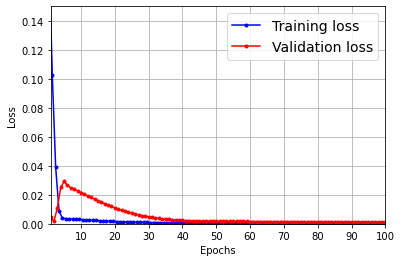

In [44]:
plot_history(history)

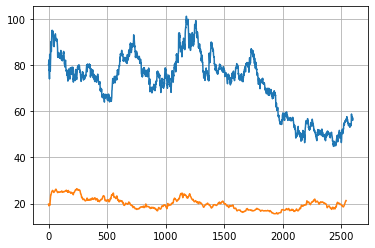

In [17]:
predictions = model.predict(train_features)
unorm = np.reshape(scaler.inverse_transform(predictions), -1)
plt.plot(dHigh_serie.values[:3000])
plt.grid(True)
plt.plot(unorm[:3000])
plt.show()

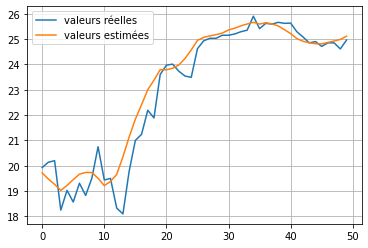

In [18]:
# Nouvelle prédiction

data=pd.read_csv('preprocessed_CAC40.csv',index_col='Date',parse_dates=True)
data = clear_data(data)
data = data[data['Name'] == 'Vivendi']
dHigh_series = data['Daily_High']
train_values = dHigh_series.values.reshape(-1, 1)

min_max_scaler = MinMaxScaler()
scaler = min_max_scaler.fit(train_values[:800])
train_values = scaler.transform(train_values)
train_features, train_labels = create_window(train_values, 0, None, 5)

predictions = model.predict(train_features)
unorm = np.reshape(scaler.inverse_transform(predictions), -1)

plt.plot(dHigh_series.values[:50])
plt.grid(True)
plt.plot(unorm[:50])
plt.legend(['valeurs réelles', 'valeurs estimées'])
plt.show()